# Result analysis

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import baseline
import numpy as np
from baseline import *
from decoder import *
from alphabet import *
from train import *
import pandas
import numpy as np
import torch
from matplotlib import pyplot as plt
import collections
import editdistance


torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.4.0'

### Dataset and language setup

In [6]:
LANGUAGE = "Python"

def filter_ascii(strings):
    'Returns only the strings that can be encoded in ASCII.'
    l = []
    for s in strings:
        try:
            s.encode('ascii')
            if 10 <= len(s) <= 80:
                l.append(s)
        except UnicodeEncodeError:
            pass

    return list(set(l))

def language_2_dataset(language='Python'):
    with open('dataset/large.json') as f:
        multilang_dataset = json.load(f)
        dataset = multilang_dataset[language]

        dataset['train'] = filter_ascii(dataset['train'])
        dataset['dev'] = filter_ascii(dataset['dev'])
        dataset['test'] = filter_ascii(dataset['test'])
        print('{} training examples, {} validation examples, {} test exampless'.format(
            len(dataset['train']), 
            len(dataset['dev']),
            len(dataset['test'])))
        return dataset
    
full_dataset = {
    "python": language_2_dataset("Python"),
    "haskell": language_2_dataset("Haskell"),
    "java": language_2_dataset("Java"),
}

602762 training examples, 80964 validation examples, 80789 test exampless
616686 training examples, 82731 validation examples, 82543 test exampless
565796 training examples, 77886 validation examples, 77884 test exampless


## Models we ran

In [7]:
python_dat = full_dataset["python"]
java_dat = full_dataset["java"]
haskell_dat = full_dataset["haskell"]

In [8]:
"""
models = [
    (UniformEncoder(removal_probability=.6),.0005, python_dat, 'python'),
    (UniformEncoder(removal_probability=.7),.0005, python_dat, 'python'), 
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'), 
    (UniformEncoder(removal_probability=.9),.0001, python_dat, 'python'), 
    (RulesBasedEncoder(), .0001, python_dat, 'python'),
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'), 
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.9, n_gram=5), .0005, python_dat, 'python'), 
    (NonDeterministicFrequencyEncoder(dataset=python_dat['train'], compression_rate=.7, n_gram=5), .0005, python_dat, 'python'),
    (FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.7, n_gram=5), .0005, python_dat, 'python'),
    (FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    (UniformFrequencyHybridEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5, removal_probability=0.8), .0005, python_dat, 'python'),
    (FrequencyEncoderConstantDrop(dataset=python_dat['train'], num_chars=5, n_gram=5), .0005, python_dat, 'python'),
    (FrequencyEncoderConstantDrop(java_dat['train'], num_chars=5, n_gram=5), .0005, java_dat, 'java'),
    (FrequencyEncoderConstantDrop(haskell_dat['train'], num_chars=5, n_gram=5), .0005, haskell_dat, 'haskell'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, python_dat, 'python'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, java_dat, 'java'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, haskell_dat, 'haskell')
    (CurriculumUniformEncoder(removal_probability=.63),.0005, python_dat, 'python'
    ]
"""
models = [
    #(UniformEncoderConstantDrop(num_chars=5), .0005, python_dat, 'python'),
    #(UniformEncoderConstantDrop(num_chars=5), .0005, java_dat, 'java'),
    #(UniformEncoderConstantDrop(num_chars=5), .0005, haskell_dat, 'haskell')
    #(FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.7, n_gram=5), .0005, python_dat, 'python'),
    #(FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    (RulesBasedEncoder(), .0001, python_dat, 'python'),
    #(UniformEncoder(removal_probability=.6),.0005, python_dat, 'python'), 
    #(UniformEncoder(removal_probability=.7),.0005, python_dat, 'python'),
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'),
    #(UniformEncoder(removal_probability=.9),.0001, python_dat, 'python'),
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    (FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    #(CurriculumUniformEncoder(removal_probability=.63),.0005, python_dat, 'python')    
]

In [9]:
def load_model(model, is_baseline=True, load_best=False):
    device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
    encoder, alpha, dataset, lang_name = model

    if load_best:
        # Load the best model saved during training.
        filename = "trained_models/{}_best_".format(encoder.name())
        loss_history_filename = "trained_models/best_model_{}".format(encoder.name())
    else:
        # Load the final model.
        filename = "trained_models/{}_{}_{}".format(encoder.name(), alpha, lang_name)
        loss_history_filename = "trained_models/{}_{}_{}.json".format(encoder.name(), alpha, lang_name)

    alphabet = AsciiEmbeddedEncoding(device)
    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)    
    decoder.load_state_dict(torch.load(filename + "decoder.model"))
    alphabet.load_state_dict(torch.load(filename + "alphabet.model"))
    
    decoder.to(device)
    alphabet.to(device)
    
    if not is_baseline:
        encoder.load_state_dict(torch.load(filename + "encoder.model"))

    with open(loss_history_filename) as f:
        j = json.load(f)
        loss_history = j["losses"]
        
    return (encoder, decoder, alphabet, lang_name, loss_history)

loaded_models = []

for m in models:
    try:
        loaded_models.append(load_model(m))
        print('Model', m[0].name(), m[3], 'loaded!')
    except Exception as e:
        print(e)
        pass
        
print(len(loaded_models), 'model(s) loaded.')

Model RulesBasedEncoderPython(whitespace=False) python loaded!
Model UniformEncoder(0.80) python loaded!
Model FrequencyEncoder(5-gram, target_size:0.8) python loaded!
Model FuzzyFrequencyEncoder(5-gram, target_size:0.8) python loaded!
4 model(s) loaded.


# Plot loss history

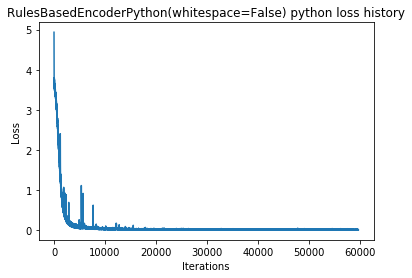

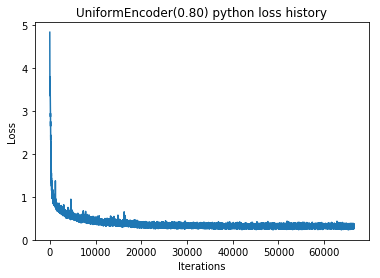

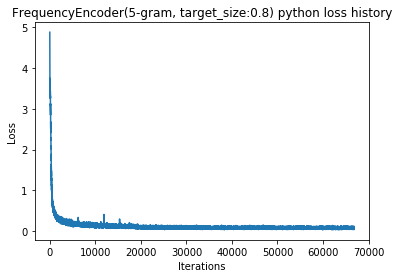

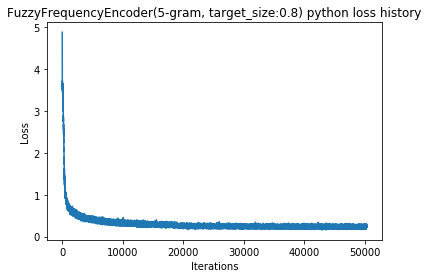

In [10]:
for (encoder, decoder, alphabet, lang, loss_history) in loaded_models:
    plt.title('{} {} loss history'.format(encoder.name(), lang))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(loss_history)
    plt.show()


# Metrics

In [11]:
BATCH_SIZE = 128

def reset_seeds():
    # Set seed before computing accuracy to make the encoders deterministic.
    np.random.seed(224)
    random.seed(224)
    torch.manual_seed(224)

# TOOD: move these to a file
def edit_distance(s1,s2):
    if len(s1)==0: return len(s2)
    if len(s2)==0: return len(s1)
    if s1[0] == s2[0]: return edit_distance(s1[1:], s2[1:])
    return 1 + min(edit_distance(s1[1:],s2),
                   edit_distance(s1,s2[1:]),
                   edit_distance(s1[1:],s2[1:]))

def batched_decode_all(model, dataset):
    reset_seeds()

    (encoder, decoder, alphabet, _, _) = model
    
    encoded_strings = [encoder.encode(s) for s in dataset]
    decoded = []    

    for i in range((len(dataset) + BATCH_SIZE - 1) // BATCH_SIZE):
        decoded.extend(decoder(encoded_strings[i*BATCH_SIZE:(i+1)*BATCH_SIZE], alphabet))

    return list(zip(dataset, encoded_strings, decoded))
    
def top1_accuracy(encoder, decoder, alphabet, dataset):
    return len(list(filter(lambda x:x[0]==x[1],
                          zip(dataset, decoder(encoder.encode_batch(dataset),alphabet))))) / len(dataset)

def top5_accuracy(encoder, decoder, alphabet, dataset):
    count = 0
    for string in dataset:
        compressed = encoder.encode(string)
        best_five = beam_search_predictions(decoder, compressed, alphabet, beam_size=5)
        if string in best_five: count += 1
    return float(count) / len(dataset)

def average(lst): return sum(lst)/len(lst)
def edit_accuracy(encoder, decoder, alphabet, dataset):
    return average([
        1-(editdistance.eval(decoder(encoder.encode(s), alphabet), 
                      s)/len(s)) for s in dataset])


# Run evaluation

The functions below are filters to compute metrics in diffetent slices of the dataset

In [19]:
def all_lines(string):
    return True

def short_lines(string):
    return len(string) <= 25

def long_lines(string):
    return len(string) >= 65

all_slices = {
    'all_lines': all_lines,
    'short_lines': short_lines,
    'long_lines': long_lines,
}

In [9]:
def evaluate(model, split, pred_filter=id):
    (encoder, decoder, alphabet, language, _) = model
    dataset = full_dataset[language][split][:100]
    dataset = list(filter(pred_filter, dataset))
    #examples = batched_decode_all(model, dataset)
    #examples = [(o, e, d) for (o, e, d) in examples if pred_filter(o, e)]
    #compression = sum(len(enc) for orig, enc, dec in examples) / sum(len(o) for (o, e, d) in examples)
    top1_acc = top1_accuracy(encoder, decoder, alphabet, dataset)
    return top1_acc#, compression

for model in loaded_models:
    print('Testing', model[0].name(), model[3])
    for split in ['test']:
        for slice_name, predicate in all_slices.items():
            top1_acc = evaluate(model, split, predicate)
            #, 'compression rate: {:.3f}'.format(compression)
            print(' ' * 8, split, slice_name, 'top-1 accuracy:', top1_acc)

Testing UniformEncoderConstantDrop(5.00) python
         test all_lines top-1 accuracy: 0.16
         test short_lines top-1 accuracy: 0.14285714285714285
         test long_lines top-1 accuracy: 0.0
Testing UniformEncoderConstantDrop(5.00) java
         test all_lines top-1 accuracy: 0.45
         test short_lines top-1 accuracy: 0.2857142857142857
         test long_lines top-1 accuracy: 0.5
Testing UniformEncoderConstantDrop(5.00) haskell
         test all_lines top-1 accuracy: 0.19
         test short_lines top-1 accuracy: 0.11428571428571428
         test long_lines top-1 accuracy: 0.18181818181818182


### Ideas
 Just consider UniformEncoder, RulesBasedEncoder, FrequencyEncoder in python first
 Figure out if rules are reconstructed by uniform or frequency
  ^Are uniform and frequency supersets of rules^
 is beam search doing the right thing?
 Seems to have a lack of predictions that terminate
  Maybe should accept a sentence as soon as the beam search yields an end
    as opposed to reconsidering after every next layer of beam search
    Can beam search be written outside of the class to prevent need for rerun?
  

In [ ]:
full_dataset['python']['dev'][1:5]

In [ ]:
for a in loaded_models:
    print(a[0],a[3])
    print(a[1](["for"],a[2]))
# does frequence learn the rules

In [ ]:
def run_models_on_string(string, models,beam=False):
    for model in models:
        (encoder, decoder, alphabet, language, _) = model
        print(encoder, "\n", decoder([string], alphabet)[0],"\n") 
        if beam:
            print(beam_search_predictions(decoder, string, alphabet, beam_size=2),"\n")

run_models_on_string("for i in rng(10):", loaded_models)
run_models_on_string("for i in rg(10):", loaded_models)

In [43]:
(encoder, decoder, alphabet, language, _) = loaded_models[-1]
dataset = full_dataset['python']['dev'][:5]
print("\n".join(dataset),"\n")
encoded = encoder.encode_batch(dataset)
print("\n".join(encoded),"\n")
print("\n".join(decoder(encoded,alphabet)))

['FE30', 'FE4F', 'CJK Compatibility Forms', [range(65072, 65104)]],
return HttpResponse("Alright")
def pam_sm_close_session(pamh, flags, argv):
0x0052: 0x0045,
def correct(self, in_file, in_time): 

['FE30', 'FE4F, J ompatibilityFors', [rane(572, 654)]
return HtpRespnse("Alrigh")
def pamsm_closesssion(pam, flags, argv):
0x0052: 0x0045,
def crrect(self, i_fie in_tme): 

['FE30', 'FE4F, J ompatibilityFors', [range(572, 654)]
return HttpRespanse("Alrigh")
def pamsm_closession(parm, flags, argv):
0x0052: 0x0045,
def crrect(self, i_file, in_tame):


In [44]:
(encoder, decoder, alphabet, language, _) = loaded_models[0]
dataset = full_dataset['python']['dev'][5:10]
print("\n".join(dataset),"\n")
encoded = encoder.encode_batch(dataset)
print("\n".join(encoded),"\n")
print("\n".join(decoder(encoded,alphabet)))

ax23 = plt.subplot2grid((12,9), (4, 4))
elif attr in self.ATTR_DATETIME:
if Prefs["get_rating"]:
score2 += 1
time = strftime("%d/%m/%Y %H:%M:%S") 

2=t.ublt2gri(29),(4, 4))
elifar  el.ATRDAEIME:
 Pr"get_rng":
s2 1
i= sme("%%/Y H:M:") 

t2 = t.subplot(2.grid(29),(4, 4))
elif arg == self.ATTRIDATE_IMAGE:
if Parse("get_range"):
s2 = 1
i = sum(replace("%(%s/Y %H:%M:%S"))


In [45]:
def succ(string):
    return set([string[:i] + string[i+1:] for i in range(len(string))])
    
def getFarthestMatchLevel(in_string, model, max_match_level=None):
    (encoder, decoder, alphabet, language, _) = model
    if in_string != decoder([in_string], alphabet)[0]: return 0
    candidates = [in_string]
    considered_strings = set([in_string])
    min_length_string = in_string
    num_at_level = {0:1}
    level_count = 0
    while candidates:
        candidate = candidates.pop()
        if len(candidate) < len(min_length_string):
            num_at_level[len(in_string) - len(min_length_string)] = level_count
            print("count at level", len(in_string) - len(min_length_string), ":", level_count, "\n")
            if max_match_level and max_match_level == len(in_string) - len(min_length_string):
                break
            min_length_string = candidate
            level_count = 0
            print(min_length_string, len(in_string) - len(min_length_string))
        level_count += 1
        potential_next_candidates = list(succ(candidate) - considered_strings)
        next_candidate_indices = list(map(lambda x:x[0],
                                          filter(lambda x:x[1]==in_string, 
                                              enumerate(decoder(potential_next_candidates, alphabet)))))
        next_candidates = [potential_next_candidates[i] for i in next_candidate_indices]
        candidates=next_candidates+candidates
        #if len(next_candidates)>0:
        #    print(next_candidates[0], len(in_string) - len(next_candidates[0]))
        considered_strings = considered_strings.union(set(next_candidates))
    return (len(min_length_string), min_length_string, num_at_level)
        


In [ ]:
getFarthestMatchLevel("for i in range(100):", loaded_models[0])

In [12]:

def models_to_name(m1,m2):
    return str((m1[0].name()+m1[3], m2[0].name()+m2[3]))

def models_to_accuracy(m1,m2,dataset,accuracy_metric):
    (encoder, _, _, _, _), (_, decoder, alphabet, _, _) = m1, m2
    return accuracy_metric(encoder, decoder, alphabet, dataset)

def accuracy_table(models, dataset, accuracy_metric=top1_accuracy):
    d = {}
    for m1 in models:
        for m2 in models:
            d[models_to_name(m1,m2)] = \
                models_to_accuracy(m1,m2,dataset,accuracy_metric) 
    return d
    
def visual_accuracy_table(models, dataset, accuracy_metric=top1_accuracy):
    return pandas.DataFrame(
            np.array([[models_to_accuracy(m1,m2,dataset,accuracy_metric) for m2 in models]
                      for m1 in models]), 
            columns = [m[0].name()+m[3] for m in models],
            index = [m[0].name()+m[3] for m in models])

In [ ]:
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:600], top1_accuracy)

In [13]:
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:100], top5_accuracy)

,RulesBasedEncoderPython(whitespace=False)python,UniformEncoder(0.80)python,"FrequencyEncoder(5-gram, target_size:0.8)python","FuzzyFrequencyEncoder(5-gram, target_size:0.8)python"
RulesBasedEncoderPython(whitespace=False)python,0.99,0.79,0.41,0.37
UniformEncoder(0.80)python,0.00,0.43,0.00,0.19
"FrequencyEncoder(5-gram, target_size:0.8)python",0.01,0.29,0.82,0.13
"FuzzyFrequencyEncoder(5-gram, target_size:0.8)python",0.00,0.02,0.00,0.48


In [9]:
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:600], top1_accuracy)

,UniformEncoder(0.60)python,UniformEncoder(0.70)python,UniformEncoder(0.80)python,UniformEncoder(0.90)python
UniformEncoder(0.60)python,0.035000,0.030000,0.036667,0.003333
UniformEncoder(0.70)python,0.081667,0.101667,0.096667,0.013333
UniformEncoder(0.80)python,0.151667,0.178333,0.220000,0.053333
UniformEncoder(0.90)python,0.291667,0.361667,0.383333,0.143333


In [11]:
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:100], top5_accuracy)

,UniformEncoder(0.60)python,UniformEncoder(0.70)python,UniformEncoder(0.80)python,UniformEncoder(0.90)python
UniformEncoder(0.60)python,0.09,0.14,0.09,0.00
UniformEncoder(0.70)python,0.17,0.24,0.20,0.05
UniformEncoder(0.80)python,0.31,0.36,0.38,0.10
UniformEncoder(0.90)python,0.46,0.61,0.68,0.27


In [29]:
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:200], edit_accuracy)

,UniformEncoder(0.60)python,UniformEncoder(0.70)python,UniformEncoder(0.80)python,UniformEncoder(0.90)python
UniformEncoder(0.60)python,0.045816,0.111806,0.201131,0.174776
UniformEncoder(0.70)python,0.050422,0.130643,0.243309,0.201023
UniformEncoder(0.80)python,0.058382,0.153800,0.271334,0.238796
UniformEncoder(0.90)python,0.066304,0.176889,0.305808,0.257084


In [23]:
def best_example(model, dataset, k=1):
    correct = list(filter(lambda x: x[0]==x[2],
                          batched_decode_all(model, dataset)))
    correct_with_fxn = [(c[1],c[0],len(c[0])-len(c[1])) for c in correct]
    return sorted(correct_with_fxn, key=lambda x: -x[2])[:k]

def worst_example(model, dataset, k=1):
    incorrect = list(filter(lambda x: x[0]!=x[2],
                          batched_decode_all(model, dataset)))
    incorrect_with_fxn = [(c[1],c[0],c[2],len(c[0])-len(c[1])) for c in incorrect]
    return sorted(incorrect_with_fxn, key=lambda x: -x[3])[:k]


In [25]:
for x in best_example(loaded_models[0], full_dataset['python']['test'][:10000], k=3): 
    print(x)
print()
#for x in worst_example(loaded_models[1], full_dataset['python']['test'][:1000], k=3): 
#    print(x)

('def_n_sef, fien paers)', 'def __init__(self, filename, parameters):', 19)
('ifnt selfeqal_lstlfmtix[i]j, sel.bakroudColor)', 'if not self.equal_list(self.matrix[i][j], self.backgroundColor):', 18)
("tart ulib2unquote(reqe.rg.get'str)", "start = urllib2.unquote(request.args.get('start'))", 16)

